In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from keras import regularizers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [28]:
df1 = pd.read_csv("../data/one-hotted-tedsd/updated_2016_3_v2.csv")
print("Finished processing ... df1");
df2 = pd.read_csv("../data/one-hotted-tedsd/updated_2016_2_v2.csv")
print("Finished processing ... df2");
df3 = pd.read_csv("../data/one-hotted-tedsd/update_2016_1_v3.csv")
print("Finished processing ... df3");
frames = [df1, df2, df3]
print("Finished processing ... frames");
original_df = pd.concat(frames)
print("This is the very original dataset size: " + str(original_df.shape))





Finished processing ... df1
Finished processing ... df2
Finished processing ... df3
Finished processing ... frames


/Users/jonahwu/miniconda3/envs/pysal2_1_release/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


This is the very original dataset size: (1458045, 248)


In [29]:
df_copy = original_df.copy(deep=True).sample(frac=1)

In [30]:
# label_df = pd.read_csv("../data/tedsd_2016_puf.csv")
# label = label_df["reason"]
# df_copy["reason"] = label
# df_copy = df_copy.sample(frac=1)
print("This is the copied dataset size: " + str(df_copy.shape))

This is the copied dataset size: (1458045, 248)


In [31]:
male_col = np.asarray(df_copy["gender_male"])
black_col = np.asarray(df_copy["race_black"])
print(np.sum(male_col))
print(np.sum(black_col))


951949.0
240912.0


In [32]:

# genderIndxNames = df_copy[(df_copy["gender_male"] == 0)].index
# print(len(genderIndxNames))
# df_copy = df_copy.drop(genderIndxNames, axis=0)
# print("This is the dataset size after removing all females" + str(df_copy.shape))
# raceIndxNames = df_copy[(df_copy['race_black'] == 0)].index
# df_copy.drop(raceIndxNames, inplace=True)
# print("This is the dataset size after removing the raceIndx: " + str(df_copy.shape))

dataset = df_copy.to_numpy()

#Extract Features
dataFields = {}
for x in range(len(df_copy.columns)):
	dataFields.update({df_copy.columns[x]: x})
print(dataFields)
indx = dataFields["reason"]
Y = dataset[:,[indx]]

# Set to binary classification problem
Y = np.select([(Y == 1)], [1] , default = 0)

{'ALCFLG': 0, 'AMPHFLG': 1, 'ARRESTS': 2, 'BARBFLG': 3, 'BENZFLG': 4, 'COKEFLG': 5, 'DSMCRIT': 6, 'HALLFLG': 7, 'HERFLG': 8, 'IDU': 9, 'INHFLG': 10, 'MARFLG': 11, 'METHFLG': 12, 'MTHAMFLG': 13, 'NOPRIOR': 14, 'OPSYNFLG': 15, 'OTCFLG': 16, 'OTHERFLG': 17, 'PCPFLG': 18, 'PSYPROB': 19, 'SEDHPFLG': 20, 'STIMFLG': 21, 'TRNQFLG': 22, 'age_approx': 23, 'alcdrug_alc': 24, 'alcdrug_both': 25, 'alcdrug_drug': 26, 'alcdrug_none': 27, 'daywait_approx': 28, 'division_enc': 29, 'division_esc': 30, 'division_ma': 31, 'division_mt': 32, 'division_ne': 33, 'division_pc': 34, 'division_sa': 35, 'division_territory': 36, 'division_wnc': 37, 'division_wsc': 38, 'educ_approx': 39, 'employ_full': 40, 'employ_nlf': 41, 'employ_part': 42, 'employ_unemployed': 43, 'employ_unknown': 44, 'ethnic_cuban': 45, 'ethnic_latino': 46, 'ethnic_mexican': 47, 'ethnic_none': 48, 'ethnic_puerto': 49, 'ethnic_unknown': 50, 'firstuse1_approx': 51, 'firstuse2_approx': 52, 'freq1_daily': 53, 'freq1_none': 54, 'freq1_some': 55, 

In [7]:
#### Constraint to hispanic Dataset
def constrainToHispanicMales(df):
    new_df = df.copy(deep=True)
    nonHispanics = new_df[(new_df['ETHNIC'] == 4)].index #4 is non-hispanic
    new_df.drop(nonHispanics, inplace=True)
    print(new_df.shape)
    raceIndxNames = new_df[(new_df['ETHNIC'] == -9)].index # 9 is missing
    new_df.drop(raceIndxNames, inplace=True)
    genderIndxNames = new_df[(new_df['GENDER']!=1)].index
    new_df.drop(genderIndxNames, inplace=True)
    print(new_df.shape)
    return new_df

hispanicDf = constrainToHispanicMales(original_df)
print(hispanicDf.shape)
print(original_df.shape)
print(hispanicDf['ETHNIC'])

KeyError: 'ETHNIC'

In [33]:
featureWeights = pd.read_csv("../data/rankedFeatures.csv")
fields = list(featureWeights["field"])
desiredChars = [fields[x] for x in range(75)]
print(desiredChars)
indxsToDelete = []
for key, value in dataFields.items():
    if key not in desiredChars:
        indxsToDelete.append(value)
# Delete the reason field for now
print()
X = np.delete(dataset, indxsToDelete, 1)
print("Shape of dataset following feature deletion: ", X.shape)
print("Label Dimensions:", Y.shape)

['service_dt_24_r', 'service_amb_nin', 'service_amb_in', 'service_re_short', 'methuse', 'psource_court', 'stfips_co', 'region_midwest', 'region_west', 'stfips_ky', 'division_mt', 'stfips_fl', 'employ_full', 'stfips_mo', 'division_sa', 'freq1_none', 'division_esc', 'division_enc', 'stfips_nj', 'psource_health', 'sub1_alcohol', 'livarag_unknown', 'stfips_md', 'ARRESTS', 'livarag_homeless', 'ALCFLG', 'race_white', 'priminc_unknown', 'psource_individual', 'region_ne', 'vet_unknown', 'marstat_single', 'sub2_none', 'priminc_wages', 'stfips_mi', 'service_re_long', 'livarag_dependent', 'sub1_weed', 'stfips_ny', 'gender_female', 'stfips_la', 'division_wnc', 'stfips_ne', 'priminc_public', 'race_black', 'OPSYNFLG', 'stfips_il', 'route1_inhalation', 'stfips_sc', 'route1_smoke', 'sub1_opiates', 'stfips_az', 'sub1_heroin', 'BENZFLG', 'ethnic_mexican', 'freq2_daily', 'route1_injection', 'sub1_unknown', 'route1_oral', 'stfips_ct', 'freq2_some', 'division_ma', 'stfips_tn', 'stfips_ks', 'division_ne', '

In [35]:
train_split_ratio = .95
def get_data(X, Y, ratio):
    assert(len(X) == len(Y))
    n_test = int(len(X) * ratio)
    trainX, testX = X[:n_test], X[n_test:]
    trainY, testY = Y[:n_test], Y[n_test:]
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = get_data(X, Y, train_split_ratio)
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("testX:", testX.shape)
print("testY:", testY.shape)

trainX: (1385142, 75)
trainY: (1385142, 1)
testX: (72903, 75)
testY: (72903, 1)


In [36]:
def create_baseline():
    model = Sequential()
    model.add(Dense(len(desiredChars), input_dim=len(desiredChars), activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(200, activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(len(desiredChars), activation = 'relu', activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

baseline_model = create_baseline()
history = baseline_model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=256, epochs=25, verbose=1)
_, train_acc = baseline_model.evaluate(trainX, trainY, verbose=0)
_, test_acc = baseline_model.evaluate(testX, testY, verbose=0)



Train on 1385142 samples, validate on 72903 samples
Epoch 1/25
1385142/1385142 [==============================] - 118s 85us/step - loss: 0.6269 - accuracy: 0.6700 - val_loss: 0.6088 - val_accuracy: 0.6777
Epoch 2/25
1385142/1385142 [==============================] - 114s 82us/step - loss: 0.6083 - accuracy: 0.6758 - val_loss: 0.6084 - val_accuracy: 0.6758
Epoch 3/25
1385142/1385142 [==============================] - 119s 86us/step - loss: 0.6067 - accuracy: 0.6763 - val_loss: 0.6098 - val_accuracy: 0.6757
Epoch 4/25
1385142/1385142 [==============================] - 137s 99us/step - loss: 0.6060 - accuracy: 0.6765 - val_loss: 0.6045 - val_accuracy: 0.6798
Epoch 5/25
1385142/1385142 [==============================] - 131s 94us/step - loss: 0.6059 - accuracy: 0.6764 - val_loss: 0.6140 - val_accuracy: 0.6716
Epoch 6/25
1385142/1385142 [==============================] - 116s 83us/step - loss: 0.6056 - accuracy: 0.6766 - val_loss: 0.6068 - val_accuracy: 0.6743
Epoch 7/25
1385142/1385142 [==

In plotting


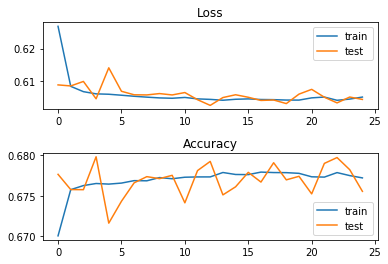

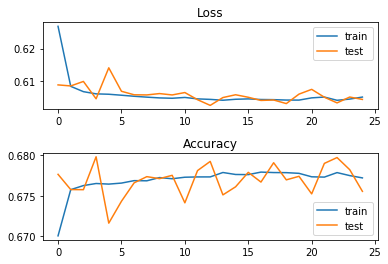

In [37]:
# plot loss during training
print("In plotting")
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.subplots_adjust(hspace=0.5)
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.subplots_adjust(hspace=0.5)
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
# Setting up our Metrics Functions.  The key idea is we use our fitted baseline_predictor to make predictions.
# We use Keras's inbuilt predict functions() to first make predictions 
yhat_probs = baseline_model.predict(testX, verbose=0)
yhat_classes = baseline_model.predict_classes(testX, verbose=0)
# The above returns a 2D array, one row for each example in test dataset, and one column for prediction
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print(np.sum(yhat_classes))

accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)





13975
Accuracy: 0.675541
Precision: 0.730877
Recall: 0.339257
F1 score: 0.463409


In [39]:
yhat_classes = baseline_model.predict_classes(trainX, verbose=0)
# The above returns a 2D array, one row for each example in test dataset, and one column for prediction
# yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print(np.sum(yhat_classes))

accuracy = accuracy_score(trainY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(trainY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(trainY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(trainY, yhat_classes)
print('F1 score: %f' % f1)


261673
Accuracy: 0.677374
Precision: 0.733828
Recall: 0.337323
F1 score: 0.462189


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.716


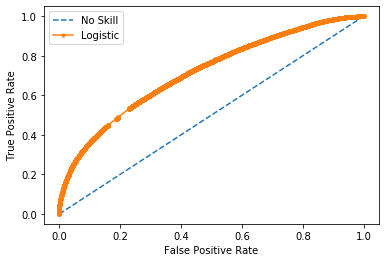

In [40]:
## Final metric is an ROC measure/curve...
ns_probs = [0 for _ in range(len(testY))]
deepNN_probs = yhat_probs
ns_auc = roc_auc_score(testY, ns_probs)
deepNN_auc = roc_auc_score(testY, deepNN_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (deepNN_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testY, ns_probs)
deepNN_fpr, deepNN_tpr, _ = roc_curve(testY, deepNN_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(deepNN_fpr, deepNN_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()